#### Frontend -> Backend -> Frontend

 - Get image array from frontend via api (or) upload image to some endpoint and get it from there
 - Convert it to 3d model 
 - send it as 3d array and only include the outer mesh

#### Converting 2d images to 3d models

**Process**
 - Take Image
 - Preprocessing
 - Depth Estimation
 - Point Cloud Generation
 - 3d Mesh generation

#### Preprocessing

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import transforms
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
threshold = 250
pad_color = (0,0,0)

def resize(img):
    height,width = img.shape[:2]
    scale = min(threshold/width, threshold/height)
    new_width = int(scale * width)
    new_height = int(scale * height)

    return cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

def pad(img):
    height,width = img.shape[:2]
    pad_top = (threshold- height) // 2
    pad_bottom = threshold - height - pad_top
    pad_left = (threshold - width) // 2
    pad_right = threshold - width - pad_left

    return cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=pad_color)

(250, 250, 3)


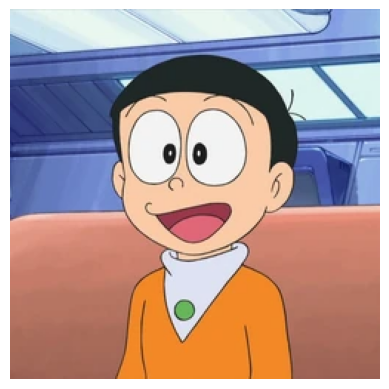

In [3]:
img = cv2.cvtColor(cv2.imread('nobita.png'), cv2.COLOR_BGR2RGB)
print(img.shape)

img = resize(img)
img = pad(img)

plt.imshow(img)
plt.axis('off')
plt.show()

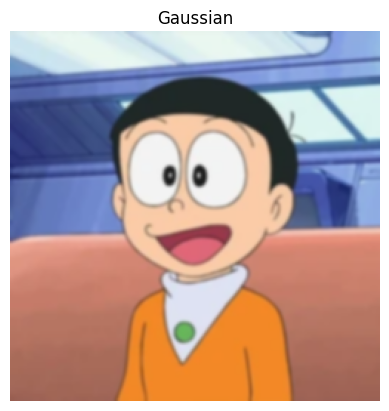

In [4]:
gaussian_img = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(gaussian_img)
plt.title('Gaussian')
plt.axis('off')
plt.show()

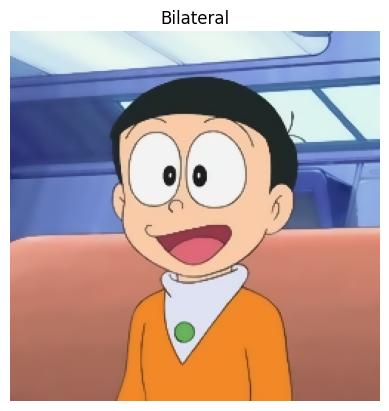

In [5]:
bilateral_img = cv2.bilateralFilter(img, 9, 75, 75)
plt.imshow(bilateral_img)
plt.title('Bilateral')
plt.axis('off')
plt.show()

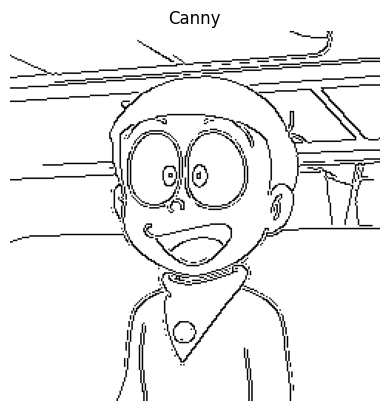

In [6]:
edges = cv2.Canny(bilateral_img, 100, 200)
plt.imshow(edges, cmap='gray_r')
plt.title('Canny')
plt.axis('off')
plt.show()

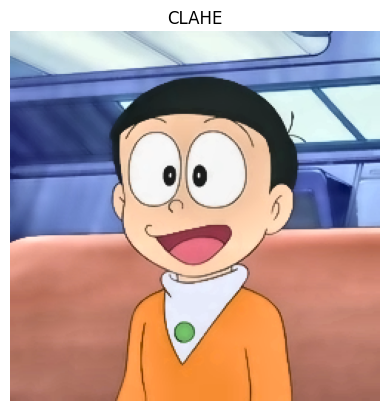

In [7]:
lab = cv2.cvtColor(bilateral_img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
l = clahe.apply(l)

enhanced_img = cv2.merge((l, a, b))
enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_LAB2BGR)

plt.imshow(enhanced_img, cmap='gray')
plt.title('CLAHE')
plt.axis('off')
plt.show()

In [8]:
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

Using cache found in C:\Users\Asus/.cache\torch\hub\intel-isl_MiDaS_master
d:\Machine Vision\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

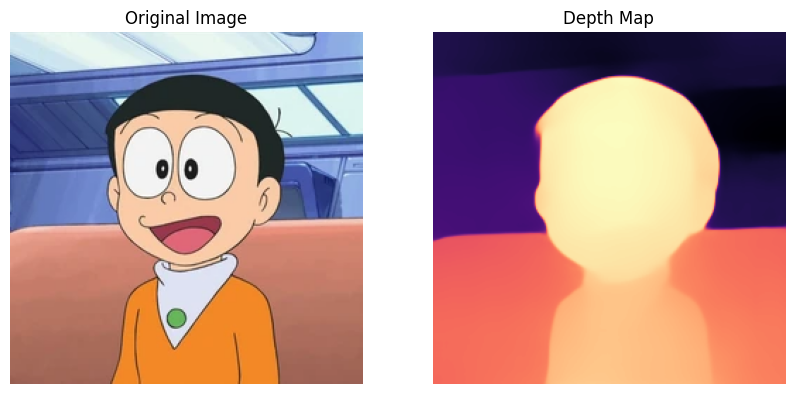

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

enhanced_img = transform(enhanced_img).unsqueeze(0).to(device)
with torch.no_grad():
    depth_map = midas(enhanced_img)
depth_map = depth_map.squeeze().cpu().numpy()
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
depth_map = cv2.resize(depth_map, (threshold,threshold))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap="magma")
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(depth_map, cmap="magma")
plt.title('Depth Map')
plt.axis('off')
plt.show()

#### Converting the depth map into a 3D point cloud

In [10]:
h,w = depth_map.shape
cx,cy = h//2, w//2
fx,fy = 50,50 # focal length

i, j = np.meshgrid(np.arange(w), np.arange(h), indexing='xy')
z = depth_map
x = (i - cx) * z / fx
y = -(j - cy) * z / fy
points = np.stack((x, y, z), axis=-1).reshape(-1, 3)


pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pcd])

In [11]:
pcd = pcd.voxel_down_sample(voxel_size=0.01)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
print('Bomar1')

radii = [0.05, 0.1, 0.2]  # Adjust based on density
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii)
)
print('Bomar2')

# Transfer colors from point cloud to mesh
mesh.vertex_colors = pcd.colors

o3d.visualization.draw_geometries([mesh])

Bomar1
Bomar2


In [12]:
o3d.io.write_triangle_mesh("output.obj", mesh)

[Open3D WARNING] Write OBJ can not include triangle normals.


True